<a href="https://colab.research.google.com/github/CleaAZolotow/batch-job-analytics/blob/master/ARIMA_TMONCICS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
#Bring in Environment note this is from https://www.datacamp.com/tutorial/arima
#Note that arima is meant for single variable analysis, not linked
#so dependency between the variables is omitted here

import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.arima.model import ARIMA


import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

from sklearn.metrics import mean_squared_error

In [8]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [11]:
data = pd.read_csv('/content/gdrive/MyDrive/TMONCICS.csv')

#Take all the text out
#subset to EPDCICS and tran HSRS <--important, this only analyzes one transaction in one sysid

data = data[data["sv_sysid"] == "EPDCICS"]
#data = data[data["tran"] == "HSRS"]
data = data[data["tran"] == "ALAF"]



data=data.drop('sv_sysid', axis=1)
data=data.drop('yywww', axis=1)
#data=data.drop('sv_date',axis=1)
data=data.drop('tran',axis=1)
#data=data.drop('hourly',axis=1)
#data=data.drop('ave_RESP',axis=1)
data=data.drop('tot_MSU',axis=1)
#data=data.drop('tot_MIPS',axis=1)
data=data.drop('tot_CPU',axis=1)
data=data.drop('tot_TRAN',axis=1)
print(data)

        sv_date       hourly  tot_MIPS  ave_RESP
89    1/11/2024   8:00:00 AM     0.008    0.0018
168   1/11/2024   9:00:00 AM     0.008    0.0025
252   1/11/2024  10:00:00 AM     0.014    0.0024
336   1/11/2024  11:00:00 AM     0.010    0.0042
420   1/11/2024  12:00:00 PM     0.007    0.0013
496   1/11/2024   1:00:00 PM     0.004    0.0018
579   1/11/2024   2:00:00 PM     0.004    0.0013
669   1/11/2024   3:00:00 PM     0.007    0.0017
757   1/11/2024   4:00:00 PM     0.004    0.0014
844   1/11/2024   5:00:00 PM     0.012    0.0015
922   1/11/2024   6:00:00 PM     0.002    0.0009
991   2/11/2024   8:00:00 AM     0.007    0.0016
1065  2/11/2024   9:00:00 AM     0.005    0.0017
1147  2/11/2024  10:00:00 AM     0.007    0.0018
1226  2/11/2024  11:00:00 AM     0.009    0.0020
1302  2/11/2024  12:00:00 PM     0.009    0.0019
1389  2/11/2024   1:00:00 PM     0.014    0.0018
1479  2/11/2024   2:00:00 PM     0.004    0.0023
1557  2/11/2024   3:00:00 PM     0.013    0.0015
1645  2/11/2024   4:

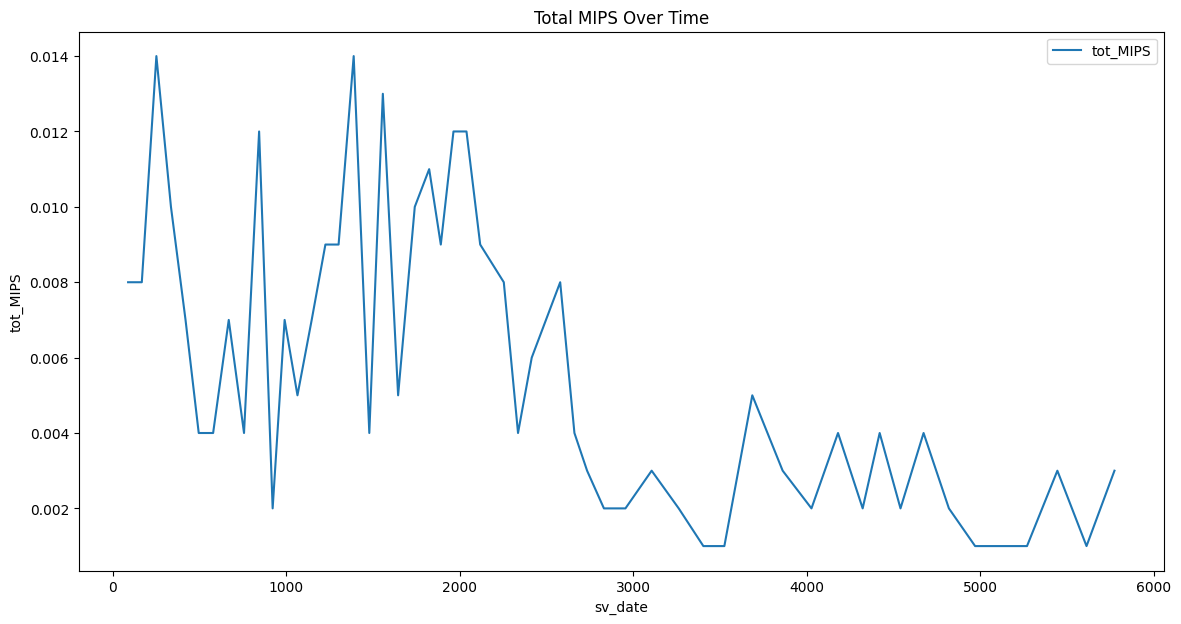

In [13]:
# Plotting the original total MIPS just to look at it
plt.figure(figsize=(14, 7))
plt.plot(data.index, data["tot_MIPS"], label='tot_MIPS')
plt.title('Total MIPS Over Time')
plt.xlabel('sv_date')
plt.ylabel('tot_MIPS')
plt.legend()
plt.show()

In [16]:
# Perform the Augmented Dickey-Fuller test on the original series
#This checks to see if the data is stationary or non-stationary
#Arima doesn't work on non-stationary data.  Non-stationary data is that considered to have a time-varying variance (i.e., inconsistent time lags)
#This may be able to be cleaned up with better filtering of the data and more of it

result_original = adfuller(data["tot_MIPS"])

print(f"ADF Statistic (Original): {result_original[0]:.4f}")
print(f"p-value (Original): {result_original[1]:.4f}")

if result_original[1] < 0.05:
    print("Interpretation: The original series is Stationary.\n")
else:
    print("Interpretation: The original series is Non-Stationary.\n")


ADF Statistic (Original): -1.7766
p-value (Original): 0.3921
Interpretation: The original series is Non-Stationary.



In [18]:
# Apply first-order differencing in order to fix non-stationary data
#To perform differencing, we subtract each observation from the previous one to
#give us a new time series of first differences.
#(The new time series is now one element shorter than the original.)
#This does not take into account seasonality

data['tot_MIPSDiff'] = data['tot_MIPS'].diff()


In [20]:
# Perform the Augmented Dickey-Fuller test on the differenced series to ensure that its stationary
result_diff = adfuller(data["tot_MIPSDiff"].dropna())
print(f"ADF Statistic (Differenced): {result_diff[0]:.4f}")
print(f"p-value (Differenced): {result_diff[1]:.4f}")
if result_diff[1] < 0.05:
    print("Interpretation: The differenced series is Stationary.")
else:
    print("Interpretation: The differenced series is Non-Stationary.")

ADF Statistic (Differenced): -6.1853
p-value (Differenced): 0.0000
Interpretation: The differenced series is Stationary.


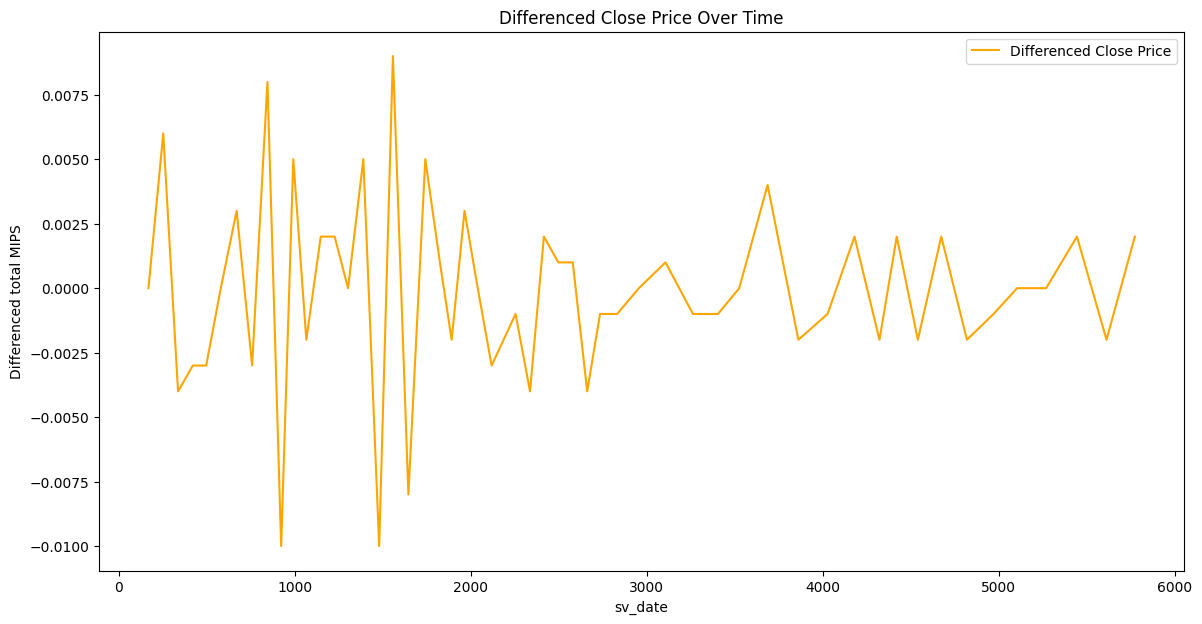

In [22]:
# Plotting the differenced Close price
plt.figure(figsize=(14, 7))
plt.plot(data.index, data['tot_MIPSDiff'], label='Differenced Close Price', color='orange')
plt.title('Differenced Close Price Over Time')
plt.xlabel('sv_date')
plt.ylabel('Differenced total MIPS')
plt.legend()
plt.show()

When we build an ARIMA model, we have to consider the p, d, and q terms that go into our ARIMA model.

The first parameter, p, is the number of lagged observations. By considering p, we effectively determine how far back in time we go when trying to predict the current observation. We do this by looking at the autocorrelations of our time series, which are the correlations in our series at previous time lags.

The second parameter, d, refers to the order of differencing, which we talked about. Again, differencing simply means finding the differences between consecutive timesteps. It is a way to make our data stationary, which means removing the trends and any changes in variance over time. d indicates differencing at which order you get a process stationary.

The third parameter q refers to the order of the moving average (MA) part of the model. It represents the number of lagged forecast errors included in the model. Unlike a simple moving average, which smooths data, the moving average in ARIMA captures the relationship between an observation and the residual errors from a moving average model applied to lagged observations.

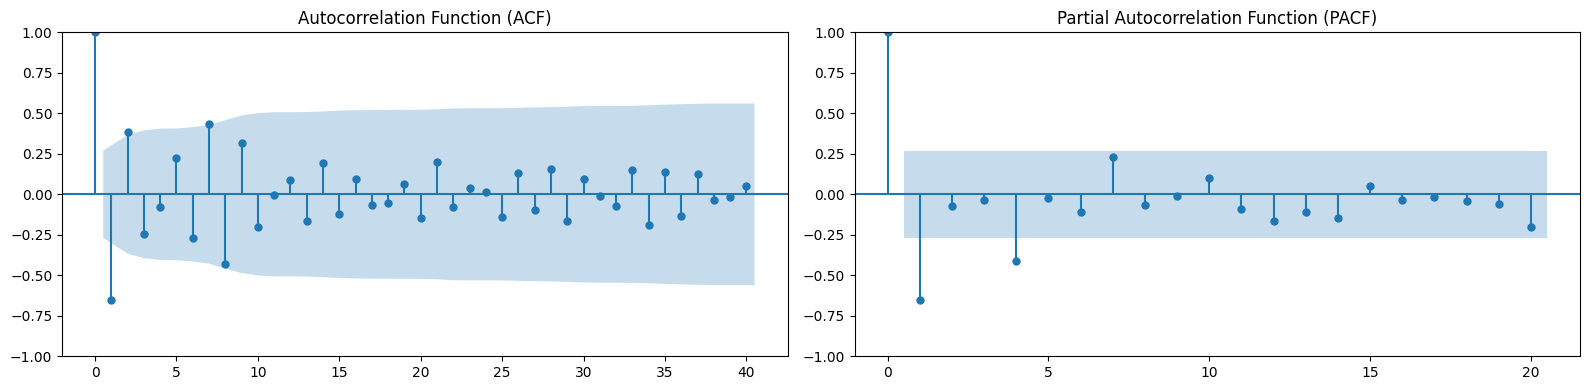

In [26]:
#tot_MIPSDiff
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Plot ACF and PACF for the differenced series
fig, axes = plt.subplots(1, 2, figsize=(16, 4))

# ACF plot
plot_acf(data['tot_MIPSDiff'].dropna(), lags=40, ax=axes[0])
axes[0].set_title('Autocorrelation Function (ACF)')

# PACF plot
plot_pacf(data['tot_MIPSDiff'].dropna(), lags=20, ax=axes[1])
axes[1].set_title('Partial Autocorrelation Function (PACF)')

plt.tight_layout()
plt.show()

In [27]:
# Split data into train and test obviously doesn't work
train_size = int(len(data) * 0.8)
train, test = data.iloc[:train_size], data.iloc[train_size:]

# Fit ARIMA model
model = ARIMA(train["tot_MIPS"], order=(1,1,1))
model_fit = model.fit()

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retv

/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


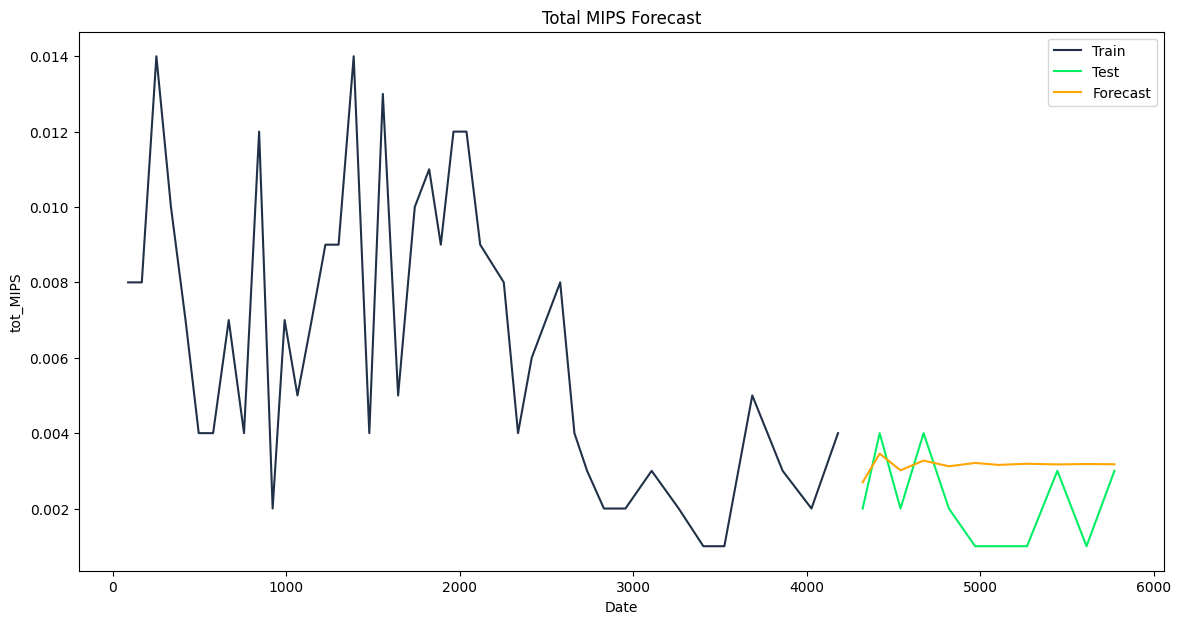

In [29]:
# Forecast
forecast = model_fit.forecast(steps=len(test))

# Plot the results with specified colors
plt.figure(figsize=(14,7))
plt.plot(train.index, train["tot_MIPS"], label='Train', color='#203147')
plt.plot(test.index, test["tot_MIPS"], label='Test', color='#01ef63')
plt.plot(test.index, forecast, label='Forecast', color='orange')
plt.title('Total MIPS Forecast')
plt.xlabel('Date')
plt.ylabel('tot_MIPS')
plt.legend()
plt.show()

In [34]:
print(f"AIC: {model_fit.aic}")
print(f"BIC: {model_fit.bic}")

forecast = forecast[:len(test)]
test_close = test["tot_MIPS"][:len(forecast)]

# Calculate RMSE - not enough data for test
rmse = np.sqrt(mean_squared_error(test_close, forecast))
print(f"RMSE: {rmse:.4f}")

AIC: -360.85344729501014
BIC: -355.64043844016004
RMSE: 0.0014


In [14]:
# fit model
model = ARIMA(data, order=(5,1,0))
model_fit = model.fit()



ValueError: Pandas data cast to numpy dtype of object. Check input data with np.asarray(data).

[[0.008]
 [0.008]
 [0.014]
 [0.01 ]
 [0.007]
 [0.004]
 [0.004]
 [0.007]
 [0.004]
 [0.012]
 [0.002]
 [0.007]
 [0.005]
 [0.007]
 [0.009]
 [0.009]
 [0.014]
 [0.004]
 [0.013]
 [0.005]
 [0.01 ]
 [0.011]
 [0.009]
 [0.012]
 [0.012]
 [0.009]
 [0.008]
 [0.004]
 [0.006]
 [0.007]
 [0.008]
 [0.004]
 [0.003]
 [0.002]
 [0.002]
 [0.003]
 [0.002]
 [0.001]
 [0.001]
 [0.005]
 [0.003]
 [0.002]
 [0.004]
 [0.002]
 [0.004]
 [0.002]
 [0.004]
 [0.002]
 [0.001]
 [0.001]
 [0.001]
 [0.003]
 [0.001]
 [0.003]]
[0.0018 0.0025 0.0024 0.0042 0.0013 0.0018 0.0013 0.0017 0.0014 0.0015
 0.0009 0.0016 0.0017 0.0018 0.002  0.0019 0.0018 0.0023 0.0015 0.0017
 0.0019 0.0015 0.0013 0.0014 0.0011 0.0012 0.0015 0.0006 0.0015 0.001
 0.001  0.0012 0.0015 0.0013 0.0017 0.0011 0.0011 0.0012 0.001  0.0014
 0.0013 0.0013 0.0015 0.001  0.002  0.0021 0.0017 0.0012 0.0019 0.0021
 0.0018 0.0016 0.001  0.0019]


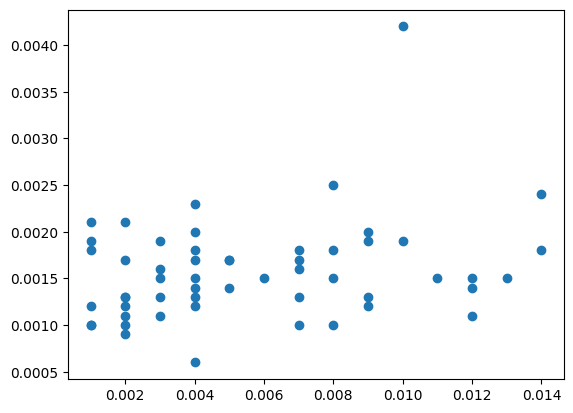

In [ ]:
# Plot the data - it is NOT exponential!
plt.scatter(X, Y)

array([[0.008],
       [0.008],
       [0.014],
       [0.01 ],
       [0.007],
       [0.004],
       [0.004],
       [0.007],
       [0.004],
       [0.012],
       [0.002],
       [0.007],
       [0.005],
       [0.007],
       [0.009],
       [0.009],
       [0.014],
       [0.004],
       [0.013],
       [0.005],
       [0.01 ],
       [0.011],
       [0.009],
       [0.012],
       [0.012],
       [0.009],
       [0.008],
       [0.004],
       [0.006],
       [0.007],
       [0.008],
       [0.004],
       [0.003],
       [0.002],
       [0.002],
       [0.003],
       [0.002],
       [0.001],
       [0.001],
       [0.005],
       [0.003],
       [0.002],
       [0.004],
       [0.002],
       [0.004],
       [0.002],
       [0.004],
       [0.002],
       [0.001],
       [0.001],
       [0.001],
       [0.003],
       [0.001],
       [0.003]])

array([-6.31996861, -5.99146455, -6.03228654, -5.47267075, -6.64539101,
       -6.31996861, -6.64539101, -6.37712703, -6.57128304, -6.50229017,
       -7.01311579, -6.43775165, -6.37712703, -6.31996861, -6.2146081 ,
       -6.26590139, -6.31996861, -6.07484616, -6.50229017, -6.37712703,
       -6.26590139, -6.50229017, -6.64539101, -6.57128304, -6.8124451 ,
       -6.72543372, -6.50229017, -7.4185809 , -6.50229017, -6.90775528,
       -6.90775528, -6.72543372, -6.50229017, -6.64539101, -6.37712703,
       -6.8124451 , -6.8124451 , -6.72543372, -6.90775528, -6.57128304,
       -6.64539101, -6.64539101, -6.50229017, -6.90775528, -6.2146081 ,
       -6.16581793, -6.37712703, -6.72543372, -6.26590139, -6.16581793,
       -6.31996861, -6.43775165, -6.90775528, -6.26590139])

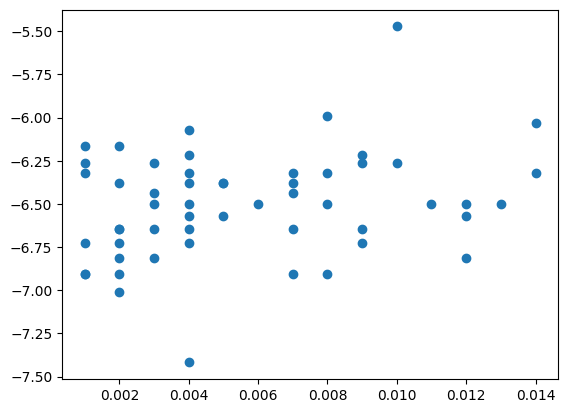

In [ ]:
# Since we want a linear model, let's take the log
Y = np.log(Y)
plt.scatter(X, Y)
# that's better
display(X,Y)


In [ ]:
# Let's also center the X data so the values are not too large
# We could scale it too but then we'd have to reverse the transformation later
X = X - X.mean()
display(X,Y)


array([[ 0.00235185],
       [ 0.00235185],
       [ 0.00835185],
       [ 0.00435185],
       [ 0.00135185],
       [-0.00164815],
       [-0.00164815],
       [ 0.00135185],
       [-0.00164815],
       [ 0.00635185],
       [-0.00364815],
       [ 0.00135185],
       [-0.00064815],
       [ 0.00135185],
       [ 0.00335185],
       [ 0.00335185],
       [ 0.00835185],
       [-0.00164815],
       [ 0.00735185],
       [-0.00064815],
       [ 0.00435185],
       [ 0.00535185],
       [ 0.00335185],
       [ 0.00635185],
       [ 0.00635185],
       [ 0.00335185],
       [ 0.00235185],
       [-0.00164815],
       [ 0.00035185],
       [ 0.00135185],
       [ 0.00235185],
       [-0.00164815],
       [-0.00264815],
       [-0.00364815],
       [-0.00364815],
       [-0.00264815],
       [-0.00364815],
       [-0.00464815],
       [-0.00464815],
       [-0.00064815],
       [-0.00264815],
       [-0.00364815],
       [-0.00164815],
       [-0.00364815],
       [-0.00164815],
       [-0

array([-6.31996861, -5.99146455, -6.03228654, -5.47267075, -6.64539101,
       -6.31996861, -6.64539101, -6.37712703, -6.57128304, -6.50229017,
       -7.01311579, -6.43775165, -6.37712703, -6.31996861, -6.2146081 ,
       -6.26590139, -6.31996861, -6.07484616, -6.50229017, -6.37712703,
       -6.26590139, -6.50229017, -6.64539101, -6.57128304, -6.8124451 ,
       -6.72543372, -6.50229017, -7.4185809 , -6.50229017, -6.90775528,
       -6.90775528, -6.72543372, -6.50229017, -6.64539101, -6.37712703,
       -6.8124451 , -6.8124451 , -6.72543372, -6.90775528, -6.57128304,
       -6.64539101, -6.64539101, -6.50229017, -6.90775528, -6.2146081 ,
       -6.16581793, -6.37712703, -6.72543372, -6.26590139, -6.16581793,
       -6.31996861, -6.43775165, -6.90775528, -6.26590139])

In [ ]:
# Now create our Tensorflow model
model = tf.keras.models.Sequential([
  tf.keras.layers.Input(shape=(1,)),
  tf.keras.layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.SGD(0.001, 0.9), loss='mse')
# model.compile(optimizer='adam', loss='mse')


# learning rate scheduler
def schedule(epoch, lr):
  if epoch >= 50:
    return 0.0001
  return 0.001


scheduler = tf.keras.callbacks.LearningRateScheduler(schedule)


# Train the model
r = model.fit(X, Y, epochs=200, callbacks=[scheduler])
#r = model.fit(X, Y, epochs=200, callbacks=[scheduler])

Epoch 1/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 42.2588 - learning_rate: 0.0010
Epoch 2/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 41.8609 - learning_rate: 0.0010
Epoch 3/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 40.7726 - learning_rate: 0.0010
Epoch 4/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 39.2601 - learning_rate: 0.0010
Epoch 5/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 37.3980 - learning_rate: 0.0010
Epoch 6/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 35.5469 - learning_rate: 0.0010
Epoch 7/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 33.2977 - learning_rate: 0.0010
Epoch 8/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 31.3375 - learning_rate: 0.0010
Epoch 9/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 29.2742 - learning_rate: 0.0010
Epoch 10/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - loss: 26.8884 - learning_rate: 0.0010
Epoch 11/200
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step - loss: 24.8230 - learning_rate: 0.0010
Epoch 12

1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step

2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step


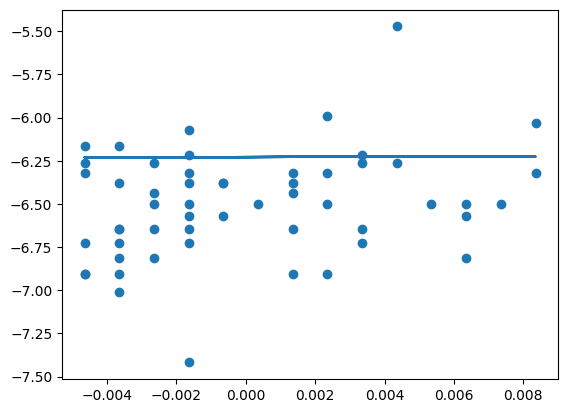

In [ ]:
# Make sure the line fits our data
Yhat = model.predict(X).flatten()
plt.scatter(X, Y)
plt.plot(X, Yhat)

In [ ]:
# Manual calculation

# Get the weights
w, b = model.layers[0].get_weights()

# Reshape X because we flattened it again earlier
X = X.reshape(-1, 1)

# (N x 1) x (1 x 1) + (1) --> (N x 1)
Yhat2 = (X.dot(w) + b).flatten()

# Don't use == for floating points
np.allclose(Yhat, Yhat2)

True